Najpierw importujemy biblioteki:

In [1]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Pobieramy dane ze strony i ładujemy do dataframe'a:

In [6]:
page = 'https://www.tibia.com/library/?subtopic=experiencetable' #stronka z poziomami
html_tables =  pd.read_html(page, header = 0)     #wyciągamy tabelki html
df = html_tables[0]    #pierwsza tabelka to poziomy punktów

df = df.iloc[1:,:2]    # wycinamy śmieci
df.columns = df.iloc[0]   #ustawiamy nazwy kolumn 

df = df.drop(1)    
df = df.drop(df[df['Level'] == 'Level'].index)  #usuwamy niepotrzebny wiersz
df = df.reset_index(drop=True)

df['Level'] = df['Level'].astype('int64')
df['Experience'] = df['Experience'].astype('int64')
xdata = df['Level']
ydata = df['Experience']

Podejrzyjmy jak wyglądają nasze dane:

In [3]:
df.head()

1,Level,Experience
0,1,0
1,2,100
2,3,200
3,4,400
4,5,800


Ostatnie wiersze:

In [4]:
df.tail()

1,Level,Experience
1595,1596,67501676000
1596,1597,67628797600
1597,1598,67756078700
1598,1599,67883519400
1599,1600,68011119800


Oglądamy sobie dane na wykresie:

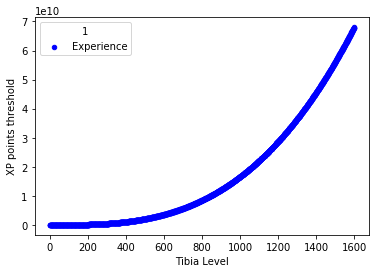

In [16]:
ax = df.plot(kind="scatter", x="Level",y="Experience", color="b", label="Experience")
ax.set_xlabel("Tibia Level")
ax.set_ylabel("XP points threshold")
plt.show()

Wygląda na coś zbliżonego do funkcji wykładniczej. Po próbach z eksponensem i wielomianami stopnia 2-4 okazuje się, że pasuje wielomian trzeciego stopnia:

In [5]:
def func(x, a, b, c, d):
    return (a * x**3 + b * x**2 + c * x + d)

Dopasowujemy krzywą i podglądamy parametry:

In [7]:
popt, pcov = curve_fit(func, xdata, ydata)
a, b, c, d = popt
popt

array([  16.66666661,  -99.99986337,  283.24669611, -184.50958238])

Wyliczamy dane z modelu i wyznaczamy błąd średniokwadratowy (RMSE):

In [19]:
df['fitted'] = df.apply(lambda x: func(x['Level'], a, b, c, d), axis=1)

RMSE = np.sqrt(mean_squared_error(df['Experience'], df['fitted']))
RMSE

6.492602402010659

Jakiś błąd jest, nie jest idealnie. Próbujemy zaokrąglić wyniki do najbliższej setki i znowu wyliczamy RMSE:

In [21]:
df['fitted_and_rounded'] = df.apply(lambda x: np.round(x['fitted'], -2), axis=1)
RMSE = np.sqrt(mean_squared_error(df['Experience'], df['fitted_and_rounded']))
RMSE

0.0

Bingo! Szukana funkcja to wielomian:

\begin{align}
16.66666661  {x^3} -99.99986337{x^2} + 283.24669611{x} -184.50958238
\end{align}

Gdzie x to numer poziomu z wynikiem zaokrąglonym do setek.